<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Part-1-Data-Preprocessing" data-toc-modified-id="Part-1-Data-Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Part 1 Data Preprocessing</a></span></li><li><span><a href="#Part-2-Graphs" data-toc-modified-id="Part-2-Graphs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Part 2 Graphs</a></span></li><li><span><a href="#Part-3-AdaBoost" data-toc-modified-id="Part-3-AdaBoost-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Part 3 AdaBoost</a></span></li><li><span><a href="#Part-4-(SVM)" data-toc-modified-id="Part-4-(SVM)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Part 4 (SVM)</a></span><ul class="toc-item"><li><span><a href="#Plotting-Decision-Boundries" data-toc-modified-id="Plotting-Decision-Boundries-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Plotting Decision Boundries</a></span></li><li><span><a href="#Hyperparameter-Tuning" data-toc-modified-id="Hyperparameter-Tuning-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Hyperparameter Tuning</a></span></li><li><span><a href="#Hard-Voting-Classifiers" data-toc-modified-id="Hard-Voting-Classifiers-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Hard Voting Classifiers</a></span></li><li><span><a href="#Convex-Optimization" data-toc-modified-id="Convex-Optimization-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Convex Optimization</a></span></li></ul></li></ul></div>

## Imports & Load Dataset

In [ ]:
# Imports
import pandas as pd
import numpy as np

# Load Dataset
dataset = pd.read_csv('JuiceQuality.csv').iloc[:,1:]

# Remove all samples with no label
dataset = dataset.dropna(subset = ['quality']).reset_index(drop = True)

# Replace nan value in numerical features with mean of its column except 'pH' & 'A Indx'
dataset['fixed acidity'] = dataset['fixed acidity'].fillna(round(dataset['fixed acidity'].mean(),1))
dataset['volatile acidity'] = dataset['volatile acidity'].fillna(round(dataset['volatile acidity'].mean(),3))
dataset['citric acid'] = dataset['citric acid'].fillna(round(dataset['citric acid'].mean(),2))
dataset['chlorides'] = dataset['chlorides'].fillna(round(dataset['chlorides'].mean(),3))
dataset['free sulfur dioxide'] = dataset['free sulfur dioxide'].fillna(round(dataset['free sulfur dioxide'].mean()))
dataset['total sulfur dioxide'] = dataset['total sulfur dioxide'].fillna(round(dataset['total sulfur dioxide'].mean()))
dataset['density'] = dataset['density'].fillna(round(dataset['density'].mean(),5))

# Replace nan value in categorical features with max frequency item in its column
dataset['residual sugar'] = dataset['residual sugar'].fillna(dataset['residual sugar'].value_counts().idxmax())
dataset['sulphates'] = dataset['sulphates'].fillna(dataset['sulphates'].value_counts().idxmax())
dataset['Vit Indx'] = dataset['Vit Indx'].fillna(dataset['Vit Indx'].value_counts().idxmax())
dataset['Type'] = dataset['Type'].fillna(dataset['Type'].value_counts().idxmax())


## Part 1 Data Preprocessing
Replace all the nan values in "PH" feature using "sulphates" feature. 

In [ ]:
# Replace nan value in 'pH' with mean of corresponding 'sulphates'
dataset['pH'] = dataset.apply(lambda row: round(dataset[dataset['sulphates'] == row['sulphates']].loc[:,'pH'].mean(),2) if np.isnan(row['pH']) else row['pH'],axis=1)


Use Linear Regression to fill out nan values. "A Indx" feature is presumed as a Label and "fixed acidity", "citric acid" and " chlorides" are our features. You can use any of the mentioned features to estimate nan values in Label. 

In [ ]:
# Linear Regression to fill out nan values in 'A Index'
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
XX = np.array(dataset.loc[:,['fixed acidity','citric acid','A Indx']].dropna().loc[:,['fixed acidity','citric acid']])
yy = np.array(dataset.loc[:,['A Indx']].dropna())

X_train = XX[0:4928]
y_train = yy[0:4928]
X_test = XX[4928:6160]
y_test = yy[4928:6160]

print('features = fixed acidity & citric acid')
regressor.fit(X_train, y_train)
print('score =', regressor.score(X_train, y_train))
y_pred = regressor.predict(X_test)
print('error =',((y_test-y_pred)**2).mean())

# Replace nan value in 'A Indx' with predicted value of LinearRegression
regressor.fit(XX, yy)
dataset['A Indx'] = dataset.apply(lambda row: (regressor.predict(np.array([[row['fixed acidity'],row['citric acid']]]))).item(0,0) if np.isnan(row['A Indx']) else row['A Indx'],axis=1)


features = fixed acidity & citric acid
score = 0.9353244355414203
error = 0.44842595383067174


Use the categorial features like "Vit Indx" to estimate nan values in " A Indx" feature. 

In [ ]:
# Adding column for converting 'residual sugar' to numerical
dataset.insert(3,'residual sugar MSB','')
dataset['residual sugar MSB'] = dataset.apply(lambda row: 0 if (row['residual sugar'] == 'very_low' or row['residual sugar'] == 'low') else 1,axis=1)
dataset['residual sugar'] = dataset.apply(lambda row: 1 if (row['residual sugar'] == 'low' or row['residual sugar'] == 'very_high') else 0,axis=1)

# Adding column for converting 'sulphates' to numerical
dataset.insert(11,'sulphates MSB','')
dataset['sulphates MSB'] = dataset.apply(lambda row: 0 if (row['sulphates'] == 'low' or row['sulphates'] == 'medium') else 1,axis=1)
dataset['sulphates'] = dataset.apply(lambda row: 1 if (row['sulphates'] == 'medium' or row['sulphates'] == 'very_high') else 0,axis=1)

# Adding column for converting 'Vit Indx' to numerical
dataset.insert(13,'Vit Indx MSB','')
dataset['Vit Indx MSB'] = dataset.apply(lambda row: 0 if (row['Vit Indx'] == 'very_low' or row['Vit Indx'] == 'low') else 1,axis=1)
dataset['Vit Indx'] = dataset.apply(lambda row: 0 if (row['Vit Indx'] == 'very_low' or row['Vit Indx'] == 'medium') else 1,axis=1)

# Linear Regression to fill out nan values in 'A Index'
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
X_train = np.array(dataset.loc[:,['residual sugar','residual sugar MSB','sulphates','sulphates MSB','Vit Indx','Vit Indx MSB','A Indx']].dropna().loc[:,['residual sugar','residual sugar MSB','sulphates','sulphates MSB','Vit Indx','Vit Indx MSB']])
y_train = np.array(dataset.loc[:,['A Indx']].dropna())
regressor.fit(X_train, y_train)

print('features = residual sugar & sulphates & Vit Indx')
regressor.fit(X_train, y_train)
print('score =', regressor.score(X_train, y_train))
y_pred = regressor.predict(X_train)
print('error =',((y_train-y_pred)**2).mean())

# Replace nan value in 'A Indx' with predicted value of LinearRegression
# dataset['A Indx'] = dataset.apply(lambda row: (regressor.predict(np.array([[row['residual sugar'],row['residual sugar MSB'],row['sulphates'],row['sulphates MSB'],row['Vit Indx'],row['Vit Indx MSB']]]))).item(0,0) if np.isnan(row['A Indx']) else row['A Indx'],axis=1)


features = residual sugar & sulphates & Vit Indx
score = 0.088524868457583
error = 7.647126540342931


In [ ]:
dataset

,fixed acidity,volatile acidity,citric acid,residual sugar MSB,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,A Indx,density,pH,sulphates MSB,sulphates,Vit Indx MSB,Vit Indx,quality,Type
0,5.9,0.320,0.39,0,1,0.114,24.0,140.0,13.905151,0.99340,3.09,0,0,0,0,high,Lemon_Juice
1,7.8,0.240,0.18,1,0,0.046,33.0,160.0,17.130070,0.99630,3.20,0,1,0,1,high,Lemon_Juice
2,7.7,0.580,0.01,0,0,0.088,12.0,18.0,15.618966,0.99568,3.25,0,1,0,1,high,Orange_Juice
3,8.3,0.180,0.30,0,0,0.033,20.0,57.0,18.085322,0.99109,3.02,0,1,1,0,high,Lemon_Juice
4,6.5,0.339,0.31,0,0,0.044,30.0,127.0,13.968160,0.99280,3.49,0,0,0,1,high,Lemon_Juice
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6155,6.0,0.170,0.33,1,0,0.036,30.0,111.0,13.602140,0.99362,3.32,0,1,0,1,high,Lemon_Juice
6156,7.0,0.310,0.31,1,1,0.036,45.0,116.0,15.227424,0.99469,2.98,0,0,1,0,high,Lemon_Juice
6157,7.3,0.260,0.33,1,1,0.056,48.0,127.0,16.240930,0.99693,3.25,0,1,0,1,high,Lemon_Juice
6158,6.4,0.230,0.35,1,0,0.039,43.0,147.0,14.171199,0.99216,3.18,0,0,1,0,high,Lemon_Juice


## Part 2 Graphs 
Calculate statistic of features.

In [ ]:
# volatile acidity
# All samples
print('volatile acidity (all sample):')
print('mean = {}'.format(dataset['volatile acidity'].mean()))
print('variance = {}'.format(dataset['volatile acidity'].var()))
print('mode = {}'.format(dataset['volatile acidity'].mode()[0]))
print('median = {}'.format(dataset['volatile acidity'].median()))
print()

# High quality samples
print('volatile acidity (high quality sample):')
print('mean = {}'.format(dataset[dataset['quality'] == 'high'].loc[:,'volatile acidity'].mean()))
print('variance = {}'.format(dataset[dataset['quality'] == 'high'].loc[:,'volatile acidity'].var()))
print('mode = {}'.format(dataset[dataset['quality'] == 'high'].loc[:,'volatile acidity'].mode()[0]))
print('median = {}'.format(dataset[dataset['quality'] == 'high'].loc[:,'volatile acidity'].median()))
print()

# Low quality samples
print('volatile acidity (low quality sample):')
print('mean = {}'.format(dataset[dataset['quality'] == 'low'].loc[:,'volatile acidity'].mean()))
print('variance = {}'.format(dataset[dataset['quality'] == 'low'].loc[:,'volatile acidity'].var()))
print('mode = {}'.format(dataset[dataset['quality'] == 'low'].loc[:,'volatile acidity'].mode()[0]))
print('median = {}'.format(dataset[dataset['quality'] == 'low'].loc[:,'volatile acidity'].median()))
print()
print('********************')
print()

# pH
# All samples
print('pH (all sample):')
print('mean = {}'.format(dataset['pH'].mean()))
print('variance = {}'.format(dataset['pH'].var()))
print('mode = {}'.format(dataset['pH'].mode()[0]))
print('median = {}'.format(dataset['pH'].median()))
print()

# High quality samples
print('pH (high quality sample):')
print('mean = {}'.format(dataset[dataset['quality'] == 'high'].loc[:,'pH'].mean()))
print('variance = {}'.format(dataset[dataset['quality'] == 'high'].loc[:,'pH'].var()))
print('mode = {}'.format(dataset[dataset['quality'] == 'high'].loc[:,'pH'].mode()[0]))
print('median = {}'.format(dataset[dataset['quality'] == 'high'].loc[:,'pH'].median()))
print()

# Low quality samples
print('pH (low quality sample):')
print('mean = {}'.format(dataset[dataset['quality'] == 'low'].loc[:,'pH'].mean()))
print('variance = {}'.format(dataset[dataset['quality'] == 'low'].loc[:,'pH'].var()))
print('mode = {}'.format(dataset[dataset['quality'] == 'low'].loc[:,'pH'].mode()[0]))
print('median = {}'.format(dataset[dataset['quality'] == 'low'].loc[:,'pH'].median()))
print()
print('********************')
print()

# A Indx
# All samples
print('A Indx (all sample):')
print('mean = {}'.format(dataset['A Indx'].mean()))
print('variance = {}'.format(dataset['A Indx'].var()))
print('mode = {}'.format(dataset['A Indx'].mode()[0]))
print('median = {}'.format(dataset['A Indx'].median()))
print()

# High quality samples
print('A Indx (high quality sample):')
print('mean = {}'.format(dataset[dataset['quality'] == 'high'].loc[:,'A Indx'].mean()))
print('variance = {}'.format(dataset[dataset['quality'] == 'high'].loc[:,'A Indx'].var()))
print('mode = {}'.format(dataset[dataset['quality'] == 'high'].loc[:,'A Indx'].mode()[0]))
print('median = {}'.format(dataset[dataset['quality'] == 'high'].loc[:,'A Indx'].median()))
print()

# Low quality samples
print('A Indx (low quality sample):')
print('mean = {}'.format(dataset[dataset['quality'] == 'low'].loc[:,'A Indx'].mean()))
print('variance = {}'.format(dataset[dataset['quality'] == 'low'].loc[:,'A Indx'].var()))
print('mode = {}'.format(dataset[dataset['quality'] == 'low'].loc[:,'A Indx'].mode()[0]))
print('median = {}'.format(dataset[dataset['quality'] == 'low'].loc[:,'A Indx'].median()))
print()
print('********************')
print()

# citric acid
# All samples
print('citric acid (all sample):')
print('mean = {}'.format(dataset['citric acid'].mean()))
print('variance = {}'.format(dataset['citric acid'].var()))
print('mode = {}'.format(dataset['citric acid'].mode()[0]))
print('median = {}'.format(dataset['citric acid'].median()))
print()

# High quality samples
print('citric acid (high quality sample):')
print('mean = {}'.format(dataset[dataset['quality'] == 'high'].loc[:,'citric acid'].mean()))
print('variance = {}'.format(dataset[dataset['quality'] == 'high'].loc[:,'citric acid'].var()))
print('mode = {}'.format(dataset[dataset['quality'] == 'high'].loc[:,'citric acid'].mode()[0]))
print('median = {}'.format(dataset[dataset['quality'] == 'high'].loc[:,'citric acid'].median()))
print()

# Low quality samples
print('citric acid (low quality sample):')
print('mean = {}'.format(dataset[dataset['quality'] == 'low'].loc[:,'citric acid'].mean()))
print('variance = {}'.format(dataset[dataset['quality'] == 'low'].loc[:,'citric acid'].var()))
print('mode = {}'.format(dataset[dataset['quality'] == 'low'].loc[:,'citric acid'].mode()[0]))
print('median = {}'.format(dataset[dataset['quality'] == 'low'].loc[:,'citric acid'].median()))
print()


volatile acidity (all sample):
mean = 0.3393456168831172
variance = 0.02561351732126233
mode = 0.339
median = 0.3

volatile acidity (high quality sample):
mean = 0.3074479140005138
variance = 0.018139850012928675
mode = 0.339
median = 0.28

volatile acidity (low quality sample):
mean = 0.3946604527296941
variance = 0.033761365562317
mode = 0.339
median = 0.339

********************

pH (all sample):
mean = 3.217097402597407
variance = 0.024539844383575565
mode = 3.25
median = 3.21

pH (high quality sample):
mean = 3.219221909393401
variance = 0.02447020855211363
mode = 3.25
median = 3.21

pH (low quality sample):
mean = 3.213413226808693
variance = 0.024650112027460758
mode = 3.18
median = 3.2

********************

A Indx (all sample):
mean = 16.05465488609038
variance = 8.391197843881669
mode = 14.349388205001821
median = 15.498437215

A Indx (high quality sample):
mean = 15.927667784114144
variance = 8.541936680334036
mode = 16.370905546266275
median = 15.37233243

A Indx (low quali

Plot Bar Graph for the "sulphates" feature for high and low quality juice.

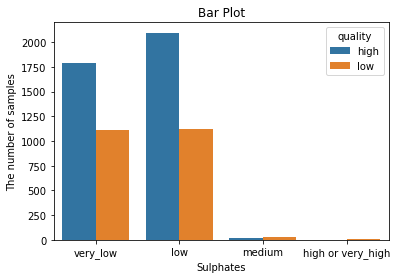

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

barframe = pd.DataFrame()
barframe['sulphates'] = 2*dataset['sulphates MSB'] + dataset['sulphates']
sulphatestag = ['very_low','low','medium','high or very_high']
barframe['sulphates'] = barframe.apply(lambda row: sulphatestag[row['sulphates']],axis=1)
barframe['quality'] = dataset['quality']
barframe = barframe.groupby(['sulphates','quality'])['sulphates'].count().reset_index(level='quality')
ax = sns.barplot(x=barframe.index, y="sulphates", hue="quality", data=barframe, order=["very_low", "low", "medium", "high or very_high"])
ax.set(xlabel='Sulphates',ylabel='The number of samples',title='Bar Plot')
plt.show()

Plot Box plot for "chlorides" feature for 4 "sulphates" group of labels and two high and low quality juice. 

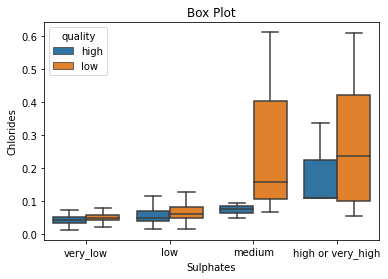

In [ ]:
boxframe = pd.DataFrame()
boxframe['sulphates'] = 2*dataset['sulphates MSB'] + dataset['sulphates']
sulphatestag = ['very_low','low','medium','high or very_high']
boxframe['sulphates'] = boxframe.apply(lambda row: sulphatestag[row['sulphates']],axis=1)
boxframe['quality'] = dataset['quality']
boxframe['chlorides'] = dataset['chlorides']
ax = sns.boxplot(x="sulphates", y="chlorides", hue="quality", data=boxframe, showfliers=False, order=["very_low", "low", "medium", "high or very_high"])
ax.set(xlabel='Sulphates',ylabel='Chlorides',title='Box Plot')
plt.show()

Plot Histogram for "free sulphor dioxide" for hight and low quailty with the distinction of juice type. 

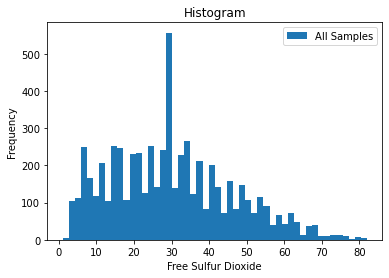

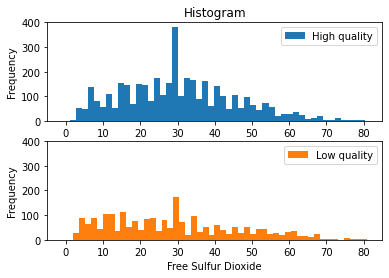

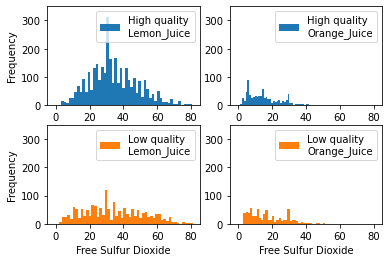

In [ ]:
# Remove outliers
import scipy.stats as ss
histframe = dataset[(np.abs(ss.zscore(dataset['free sulfur dioxide'])) < 3)].reset_index(drop = True)

# all samples
plt.figure()
plt.hist(histframe['free sulfur dioxide'],bins=50, color = "tab:blue")
plt.xlabel('Free Sulfur Dioxide')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.legend(['All Samples'])
plt.show() 

# based on quality
plt.figure()
plt.subplot(211)
plt.hist(histframe[histframe['quality']=='high'].loc[:,'free sulfur dioxide'],bins=50, color = "tab:blue")
plt.title('Histogram')
plt.ylabel('Frequency')
plt.legend(['High quality'])
plt.xlim(-5, 85)
plt.ylim(0, 400)
plt.subplot(212)
plt.hist(histframe[histframe['quality']=='low'].loc[:,'free sulfur dioxide'],bins=50, color = "tab:orange")
plt.xlabel('Free Sulfur Dioxide')
plt.ylabel('Frequency')
plt.legend(['Low quality'])
plt.xlim(-5, 85)
plt.ylim(0, 400)
plt.show() 

# based on quality and type
plt.figure()
plt.subplot(221)
plt.hist(histframe[(histframe['quality']=='high') & (histframe['Type']=='Lemon_Juice')].loc[:,'free sulfur dioxide'],bins=50, color = "tab:blue")
plt.legend(['High quality\nLemon_Juice'])
plt.ylabel('Frequency')
plt.xlim(-5, 85)
plt.ylim(0, 350)
plt.subplot(222)
plt.hist(histframe[(histframe['quality']=='high') & (histframe['Type']=='Orange_Juice')].loc[:,'free sulfur dioxide'],bins=50, color = "tab:blue")
plt.legend(['High quality\nOrange_Juice'])
plt.xlim(-5, 85)
plt.ylim(0, 350)
plt.subplot(223)
plt.hist(histframe[(histframe['quality']=='low') & (histframe['Type']=='Lemon_Juice')].loc[:,'free sulfur dioxide'],bins=50, color = "tab:orange")
plt.legend(['Low quality\nLemon_Juice'])
plt.xlabel('Free Sulfur Dioxide')
plt.ylabel('Frequency')
plt.xlim(-5, 85)
plt.ylim(0, 350)
plt.subplot(224)
plt.hist(histframe[(histframe['quality']=='low') & (histframe['Type']=='Orange_Juice')].loc[:,'free sulfur dioxide'],bins=50, color = "tab:orange")
plt.legend(['Low quality\nOrange_Juice'])
plt.xlabel('Free Sulfur Dioxide')
plt.xlim(-5, 85)
plt.ylim(0, 350)
plt.show() 

Plot heat map for the first 12 column. Compare the correlation between features. 

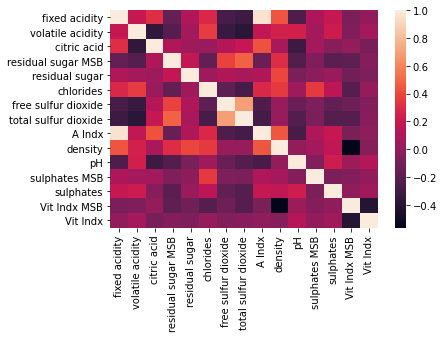

In [ ]:
ax = sns.heatmap(dataset.iloc[:,0:15].corr())

## Part 3 AdaBoost
Use a 5-fold cross validaiton to tune parameters. Utilize DecisionTreeClassifier for the base classifier.
 max_depth must be chosen from {1,3,5} and n_estimators are chosen from {10,50,100,200}. 

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

X = dataset.iloc[:,0:15]
y = dataset.iloc[:,15]
y = y.replace(['low','high'],[-1,1])

n_estimators = [10,50,100,200]
max_depth = [1,3,5]

best_n = 0
best_m = 0
score = 0;

for i in n_estimators:
    for j in max_depth:
        DSNTR = DecisionTreeClassifier(max_depth = j)
        ADBST = AdaBoostClassifier(n_estimators = i, base_estimator = DSNTR)
        tmpscr = cross_val_score(ADBST,X,y,cv=5).mean()
        if tmpscr > score:
            clf = ADBST
            score = tmpscr
            best_n = i
            best_m = j;

print('n_estimators =')
print(best_n)
print('\nmax_depth =')
print(best_m)
print('\nscore =')
print(score)

n_estimators =
200

max_depth =
5

score =
0.7564935064935064


Report F1 score, accuracy and Confusion matrix for the optimum paramters. 

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

clf.fit(X,y)
y_pred = clf.predict(X)

print('f1_score =')
print(f1_score(y,y_pred, average='binary'))
print('\naccuracy_score =')
print(accuracy_score(y,y_pred))
print('\nconfusion_matrix =')
print(confusion_matrix(y,y_pred))

f1_score =
1.0

accuracy_score =
1.0

confusion_matrix =
[[2253    0]
 [   0 3907]]


Plot the two-class decision scores. Use the decision_function of you classifier. 

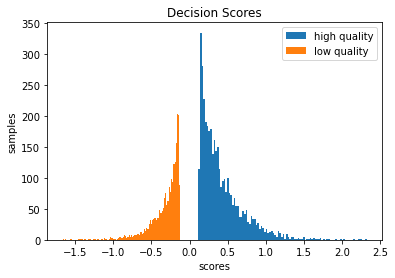

In [ ]:
plt.figure()
plt.hist(clf.decision_function(X)[y==1],bins=100)
plt.hist(clf.decision_function(X)[y==-1],bins=100)
plt.legend(['high quality','low quality'])
plt.title('Decision Scores')
plt.xlabel('scores')
plt.ylabel('samples')
plt.show() 

## Part 4 (SVM)
In this part we are going to feed the preprocessed data (like previous parts) into a SVM classifier. Before that, let us try SVM on a toy dataset (2D), which illustrates two concentric circles, and draw its decision boundries. This is to get a better feeling of how SVM with a kernel function separates nonlinear data. Necessary libraries are imported below. Google them to find out how they are used.
### Plotting Decision Boundries

In [ ]:
from sklearn.datasets.samples_generator import make_circles
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC

XX, yy = make_circles(n_samples=1000, noise=0.1, factor=0.2)

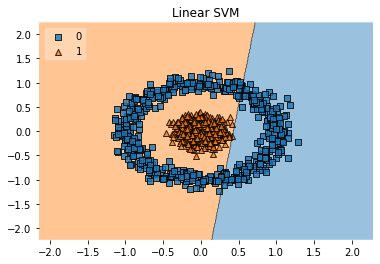

In [ ]:
# SVM with Linear Kernel:
clf = SVC(kernel='linear')
clf.fit(XX, yy)
fig = plot_decision_regions(X=XX, y=yy, clf=clf, legend=2)
plt.title('Linear SVM')
plt.show()

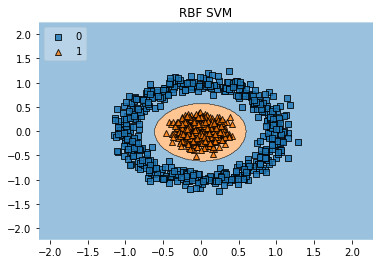

In [ ]:
# SVM with RBF Kernel:
clf = SVC(kernel='rbf')
clf.fit(XX, yy)
fig = (X=XX, y=yy, clf=clf, legend=2)
plt.title('RBF SVM')
plt.show()

### Hyperparameter Tuning
There are a wide variety of kernel functions like linear, poly, rbf, and sigmoid. Besides, we need to decide what the value of C (regularization parameter in soft-margin SVM) should be. In case of rbf, there is yet another parameter $\gamma$ that needs to be determined. 

$$Kernel Function \in \{linear, poly, rbf, sigmoid\}$$

$$C \in \{0.1, 1, 10, 100, 1000, 10000\}$$

$$\gamma \in \{0.001, 0.01, 0.1\}$$

Write a function (however you wish) to try all possible combinations (36 overall). Sort them based on their $F_1$ Score, and print them similar to the line below:

Print: #(rank), Classifier, $F_1$ Score, Accuracy, Precision, C, $\gamma$ (empty or NAN if not applicable)<br><br>
Draw the confusion matrix only for the best classifier. 
Please also note that 5-fold cross-validation must be used to estimate the scores.


In [ ]:
def clffit (clf,C,X,y,g=np.nan):
    if clf == 'brf':
        svmclf = SVC(C=C,kernel=clf,gamma=g)
    else:
        svmclf = SVC(C=C,kernel=clf)
    
    f1sc = cross_val_score(svmclf,X,y,cv=5,scoring='f1').mean()
    acsc = cross_val_score(svmclf,X,y,cv=5,scoring='accuracy').mean()
    prsc = cross_val_score(svmclf,X,y,cv=5,scoring='precision').mean()
    
    return({'Classifier':clf,'F1_Score':f1sc,'Accuracy':acsc,'Precision':prsc,'C':C,'Gamma':g})

C = [0.1,10]
g = 0.01
clf = ['linear','poly','sigmoid']

result = pd.DataFrame(columns=['Classifier','F1_Score','Accuracy','Precision','C','Gamma'])

for i in C:
    for j in clf:
        result = result.append(clffit(j,i,X,y), ignore_index=True)

for i in C:
    result = result.append(clffit('rbf',i,X,y,g), ignore_index=True)   

result = result.sort_values(by='F1_Score', ascending=False).reset_index(drop=True)
result.insert(0,'Rank','')
result['Rank'] = result.index+1
print(result)

   Rank Classifier  F1_Score  Accuracy  Precision     C  Gamma
0     1     linear  0.795315  0.714286   0.728836   0.1    NaN
1     2     linear  0.793665  0.720617   0.746632  10.0    NaN
2     3       poly  0.777380  0.637013   0.636143  10.0    NaN
3     4       poly  0.776199  0.634253   0.634253   0.1    NaN
4     5        rbf  0.776199  0.634253   0.634253   0.1   0.01
5     6        rbf  0.776038  0.635227   0.635490  10.0   0.01
6     7    sigmoid  0.674745  0.581981   0.666152   0.1    NaN
7     8    sigmoid  0.665404  0.575649   0.665662  10.0    NaN


In [ ]:
bestclf = SVC(C=0.1,kernel='linear')
bestclf.fit(X,y)
y_pred = bestclf.predict(X)
print('confusion_matrix =')
print(confusion_matrix(y,y_pred))

confusion_matrix =
[[1006 1247]
 [ 491 3416]]


### Hard Voting Classifiers

Briefly explain what hard voting (aka majority voting) is. Then perform this classification using Logistic Regression, Decision Trees, and SVM. For more information, visit:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression(max_iter=1e6)
clf2 = DecisionTreeClassifier(max_depth=5)
clf3 = SVC(C=0.1,kernel='linear')

eclf = VotingClassifier(estimators=[('lr', clf1), ('dtc', clf2), ('svm', clf3)], voting='hard')

f1sc = cross_val_score(eclf,X,y,cv=5,scoring='f1').mean()
acsc = cross_val_score(eclf,X,y,cv=5,scoring='accuracy').mean()
prsc = cross_val_score(eclf,X,y,cv=5,scoring='precision').mean()
    
print('f1_score =')
print(f1sc)
print('\naccuracy_score =')
print(acsc)
print('\nprecision_score =')
print(prsc)
eclf.fit(X,y)
y_pred = eclf.predict(X)
print('\nconfusion_matrix =')
print(confusion_matrix(y,y_pred))

f1_score =
0.7948759687233131

accuracy_score =
0.7214285714285714

precision_score =
0.7457971720210674

confusion_matrix =
[[1139 1114]
 [ 568 3339]]


### Convex Optimization

We are going to very briefly and easily look at how we go about solving optimization problems that we encounter when solving SVM. Here we use the same quadratic programming (use solvers.qp()) present in the theory problem set 3. Verify your theoretical solutions with Python code.

https://cvxopt.org/


$$min\hspace{3mm} J = (x_1-6)^2+(x_2-6)^2$$

$$s.t. \hspace{3mm}2 x_1+4 x_2 \leq 28$$

$$5 x_1 + 5 x_2 \leq 50$$

$$x_1 \leq 8$$

$$x_2 \leq 6$$

$$x_1 \geq 0$$

$$x_2 \geq 0$$

In [ ]:
from cvxopt import matrix, solvers
P = matrix([2.0,0.0,0.0,2.0],(2,2))
q = matrix([-12.0,-12.0],(2,1))
G = matrix([2.0,5.0,1.0,0.0,-1.0,0.0,4.0,5.0,0.0,1.0,0.0,-1.0],(6,2))
h = matrix([28.0,50.0,8.0,6.0,0.0,0.0],(6,1))

sol = solvers.qp(P, q, G, h)
print()
print("QP solution:")
print(sol['x'])
print("QP optimal value:")
print(sol['primal objective']+72)

     pcost       dcost       gap    pres   dres
 0: -6.9364e+01 -9.8457e+01  7e+01  7e-02  4e+00
 1: -6.8205e+01 -7.5087e+01  7e+00  3e-03  2e-01
 2: -6.8712e+01 -6.8986e+01  3e-01  6e-05  4e-03
 3: -6.8799e+01 -6.8802e+01  3e-03  7e-07  4e-05
 4: -6.8800e+01 -6.8800e+01  3e-05  7e-09  4e-07
 5: -6.8800e+01 -6.8800e+01  3e-07  7e-11  4e-09
Optimal solution found.

QP solution:
[ 5.20e+00]
[ 4.40e+00]

QP optimal value:
3.200000087541369


$$min\hspace{3mm} J = x_2^2$$

$$s.t. \hspace{3mm}x_1+x_2 \leq 10$$

$$x_1 \geq 0$$

$$x_1 \leq 5$$

In [ ]:
P = matrix([0.0,0.0,0.0,2.0],(2,2))
q = matrix([0.0,0.0],(2,1))
G = matrix([1.0,-1.0,1.0,1.0,0.0,0.0],(3,2))
h = matrix([10.0,0.0,5.0],(3,1))

sol = solvers.qp(P, q, G, h)
print()
print("QP solution:")
print(sol['x'])
print("QP optimal value:")
print(sol['primal objective'])

     pcost       dcost       gap    pres   dres
 0:  3.5156e+00 -9.9219e+00  1e+01  2e-17  8e+00
 1:  3.2006e-05 -8.9857e-01  9e-01  1e-16  2e-01
 2:  3.2562e-09 -8.9932e-03  9e-03  2e-16  2e-03
 3:  3.2562e-13 -8.9932e-05  9e-05  1e-16  2e-05
 4:  3.2562e-17 -8.9932e-07  9e-07  8e-17  2e-07
 5:  3.2562e-21 -8.9932e-09  9e-09  8e-17  2e-09
Optimal solution found.

QP solution:
[ 4.43e+00]
[ 5.71e-11]

QP optimal value:
3.256185311706768e-21


Thank you!

![alt text](https://drive.google.com/uc?export=view&id=1Sgj1xm4M9fkcxA7nRYU_TNB1qjzgQD-T)